## Character-level recurrent sequence-to-sequence model for translating English to French

Refer: https://keras.io/examples/nlp/lstm_seq2seq/

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
batch_size = 64 #batch size for training
epochs = 100 #number of epochs to train for
latent_dim = 256 #latent dimensionality of the encoding space
num_samples = 10000 #number of samples to train on

#path to the data txt file
data_path = "data/fra-eng/fra.txt"

In [3]:
#vectorize the data
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines [:min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # we use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_texts[0:10]

['Go.',
 'Hi.',
 'Hi.',
 'Run!',
 'Run!',
 'Who?',
 'Wow!',
 'Fire!',
 'Help!',
 'Jump.']

In [5]:
target_texts[0:10]

['\tVa !\n',
 '\tSalut !\n',
 '\tSalut.\n',
 '\tCours\u202f!\n',
 '\tCourez\u202f!\n',
 '\tQui ?\n',
 '\tÇa alors\u202f!\n',
 '\tAu feu !\n',
 "\tÀ l'aide\u202f!\n",
 '\tSaute.\n']

In [6]:
len(input_texts), len(target_texts)

(10000, 10000)

In [7]:
len(input_characters), len(target_characters)

(71, 94)

In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [9]:
print("Number of Samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of Samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [10]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [11]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

In [12]:
# one-hot representation
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data wil be ahead by one timestep
            # and will not include the start character
            decoder_target_data[i, t-1, target_token_index[char]] = 1.
    decoder_input_data[i, t+1:, target_token_index[" "]] = 1.
    decoder_target_data[i, t:, target_token_index[" "]] = 1.

In [13]:
encoder_input_data[0].shape

(15, 71)

In [14]:
# define an input sequence and process it
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# we discard "encoder_outputs" and only keep the states
encoder_states = [state_h, state_c]

In [15]:
# set up the decoder, using "encoder_states" as initial state
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# we set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                    initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
# define the model that will turn
# encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [17]:
# run training
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
             metrics=["accuracy"])

In [20]:
#fit
model_history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
         batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 41s 302ms/step - loss: 0.2252 - accuracy: 0.9315 - val_loss: 0.4571 - val_accuracy: 0.8727
Epoch 2/100
125/125 [==============================] - 36s 287ms/step - loss: 0.2148 - accuracy: 0.9346 - val_loss: 0.4642 - val_accuracy: 0.8709
Epoch 3/100
125/125 [==============================] - 33s 266ms/step - loss: 0.2076 - accuracy: 0.9367 - val_loss: 0.4642 - val_accuracy: 0.8724
Epoch 4/100
125/125 [==============================] - 33s 261ms/step - loss: 0.2011 - accuracy: 0.9387 - val_loss: 0.4688 - val_accuracy: 0.8718
Epoch 5/100
125/125 [==============================] - 33s 262ms/step - loss: 0.1945 - accuracy: 0.9406 - val_loss: 0.4691 - val_accuracy: 0.8732
Epoch 6/100
125/125 [==============================] - 32s 259ms/step - loss: 0.1883 - accuracy: 0.9425 - val_loss: 0.4759 - val_accuracy: 0.8732
Epoch 7/100
125/125 [==============================] - 32s 260ms/step - loss: 0.1824 - accuracy: 0.9441 - val_loss: 0.4775 -

Epoch 57/100
125/125 [==============================] - 33s 264ms/step - loss: 0.0527 - accuracy: 0.9821 - val_loss: 0.7178 - val_accuracy: 0.8694
Epoch 58/100
125/125 [==============================] - 33s 268ms/step - loss: 0.0521 - accuracy: 0.9823 - val_loss: 0.7199 - val_accuracy: 0.8686
Epoch 59/100
125/125 [==============================] - 33s 266ms/step - loss: 0.0512 - accuracy: 0.9824 - val_loss: 0.7297 - val_accuracy: 0.8689
Epoch 60/100
125/125 [==============================] - 33s 266ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 0.7342 - val_accuracy: 0.8689
Epoch 61/100
125/125 [==============================] - 34s 271ms/step - loss: 0.0491 - accuracy: 0.9833 - val_loss: 0.7416 - val_accuracy: 0.8674
Epoch 62/100
125/125 [==============================] - 33s 268ms/step - loss: 0.0488 - accuracy: 0.9832 - val_loss: 0.7449 - val_accuracy: 0.8675
Epoch 63/100
125/125 [==============================] - 34s 268ms/step - loss: 0.0479 - accuracy: 0.9835 - val_loss: 0

In [22]:
#save the model as a h5 file
model.save("eng_to_fr.h5")

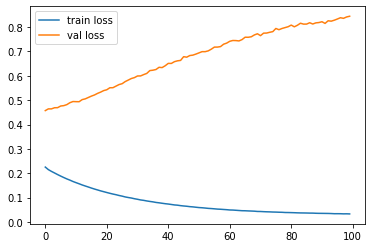

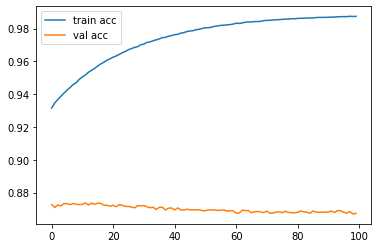

In [25]:
# plot the loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()